## Explanations

1. Identifying samples with distored ratio.
    
In order to detect ratio distorted in samples I used the following simple approach:
1. Normalize the ratio random variable (i.e. subtract mean and divide by sigma)
2. Pick values beyond the given theshold (1 by default, which approx. equals to 60% of sample).
3. Count how many samples are greater and less than 1.
4. If those greater than 1 prevail pick them, else pick those less than 1.

Step 2 implies that most of samples are good. Steps 3 and 4 ensure that the ratio remains same in case of small deviations.

Function find_destored_peptides implements this idea. It shows some warnings about zero division and nan comparations, but it's fine as we are using masks. There's an issue about np.ma warnings: https://github.com/numpy/numpy/issues/4959

2. Propose a mechanism for correcting the intensity of individual fragments based on their ratios.

First, we need to find a distorted fragment. Using the method from task 1. for a single sample S we can find what ratios have been distored. Suppose S have 4 fragments: f1, f2, f3, f4. Then we should have 3 ratios: f1/f2, f2/f3, f3/f4 and 3 bool values indicating the distortion of corresponding catios: [A, B, C]. There are few situations possible:
    1. One of A, B, C is true and others are false. That means that only single fragment has been distorted. If, for instance, A=true, B,C=false then f1 is distorted. 
    2. Two of A, B, C are true. In that case we can exclude one undistorted fragment (let it be f1 for instance). Then we might compute rartios: f2/f1, f3/f1, f4/f1. Now we now for sure that f1 is undistorted and hence if f2/f1 is distorted then f2 is distorted etc.
    3. All of A, B, C are true. We should rearrange ratios so that at least one of them is undistorted and go to step 2. If we can't find undistorted ratios that means that most of the measurements were bad and there's nothing we ca do.
The above algorithm could be generalized for any number of fragments. 

Now we have distorted fragments detected. In order to correct the intensity values we can simply set it to value that makes a correct ratio. Say f2 is distorted and f1 is not. We know the mean M of f1/f2 among the samples, then for a given sample we set f2 = f1/M.

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_excel('test_data.xlsx')

In [3]:
def find_distorted_peptides(df, std_threshold=1):
    res = defaultdict(lambda: {})
    # for each peptide
    for p in df['Peptide'].unique():
        # for each peptide label
        for label in ['Heavy', 'Light']:
            # all intensity measurments for this peptide
            samples = df[(df['Peptide'] == p)&(df['Label'] == label)]
            # names of peptide's fragments
            fragments = samples['Fragment']
            # all intensity values for this peptide
            intensities = samples.iloc[:,3:].values
            # all ratios for consecutive pairs of fragments (i.e. f1/f2, f2/f3, f3/f4 etc.)
            ratios = intensities[:-1, :]/intensities[1:, :]
            # mask inf/nan
            m = np.ma.masked_invalid(ratios)
            # count how far a single measurement from its mean in its std scale
            stds = (np.abs(m - m.mean(axis=1, keepdims=True))/
                    m.std(axis=1, keepdims=True))
            
            dest_samples = set()
            for s, r in zip(stds, ratios):
                goods = np.where((np.isfinite(r))&(s.data<=std_threshold), r, np.nan)
                lt_1 = (goods<1).sum()
                gt_1 = (goods>1).sum()
                if lt_1 > gt_1:
                    dest_samples.update(np.argwhere((~s.mask)&(r>=1)).reshape(-1))
                else:
                    # not good: what if we have lt_1 == gt_1? 
                    # we need to think more then
                    dest_samples.update(np.argwhere((~s.mask)&(r<=1)).reshape(-1))
                dest_samples.update(np.argwhere((~s.mask)&(s>std_threshold)).reshape(-1))
                dest_samples.update(np.argwhere(s.mask).reshape(-1))
            res[p][label] = [f'S{it+2}' for it in dest_samples]
    
    return res

In [4]:
r = find_distorted_peptides(df, std_threshold=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater


Let's take a look at some peptided to see how it works.

In [5]:
def plot_peptide(df, p, l):
    """Plot peptide's intensity peaks"""
    samples = df[(df['Peptide'] == p)&(df['Label'] == l)]
    intensities = samples.iloc[:,3:].values
    colors = ['red', 'green', 'blue', 'yellow', 'purple', 'black']
    for i in range(intensities.shape[0]):
        plt.plot(intensities[i], 'ro', color=colors[i])

### Peptide 2

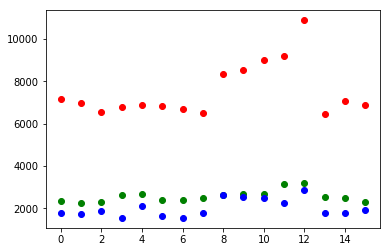

In [6]:
plot_peptide(df, 'P2', 'Heavy')

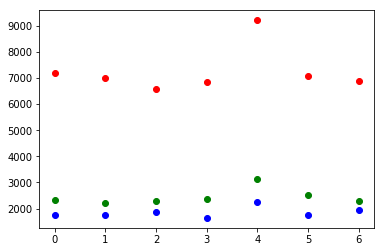

In [7]:
# drop intensities with distorted ratios
plot_peptide(df.drop(r['P2']['Heavy'], axis=1), 'P2', 'Heavy')

### Peptide 15
We can clearly see distorted peaks at the plot below and good peaks after dropping bad ones out.

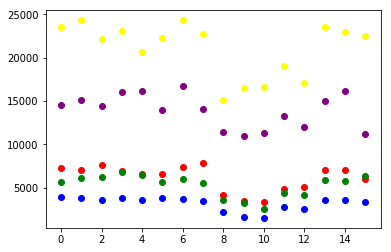

In [8]:
plot_peptide(df, 'P15', 'Heavy')

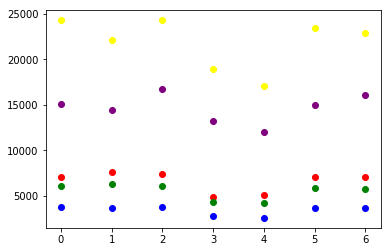

In [9]:
# drop intensities with distorted ratios
plot_peptide(df.drop(r['P15']['Heavy'], axis=1), 'P15', 'Heavy')